In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

2025-06-16 16:49:05.925960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# model = load_model('/home/users/dprimosc/L1METML/experiments/25Jun7_pruning/25Jun7_pruningmodel.h5',
#    custom_objects={'PruneLowMagnitude': prune_low_magnitude})
from loss import custom_loss_wrapper

model = load_model(
    "/home/users/dprimosc/L1METML/experiments/l1metml_v1/25May21_normf100_clip_140X/25May21_normf100_clip_140Xmodel.h5",
    custom_objects={"custom_loss": custom_loss_wrapper},
)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_cat0 (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_cat1 (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 embedding0 (Embedding)      (None, 128, 2)               12        ['input_cat0[0][0]']          
                                                                                                  
 embedding1 (Embedding)      (None, 128, 2)               8         ['input_cat1[0][0]']          
                                                                                              

% of zeros = 0.0


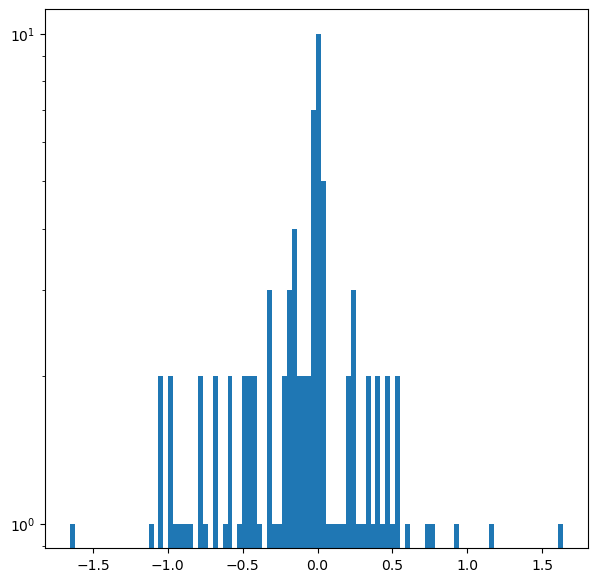

In [9]:
w = model.layers[7].weights[0].numpy()
h, b = np.histogram(w, bins=100)

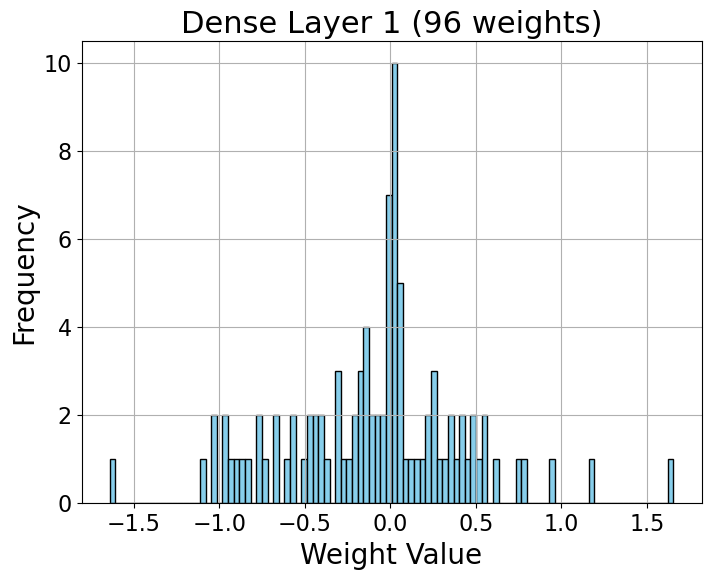

In [14]:
num_weights = w.size
plt.figure(figsize=(8, 6))
plt.hist(w.flatten(), bins=100, color="skyblue", edgecolor="black")
plt.xlabel("Weight Value", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title(f"Dense Layer 1 ({num_weights} weights)", fontsize=22)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.grid(True)
plt.show()

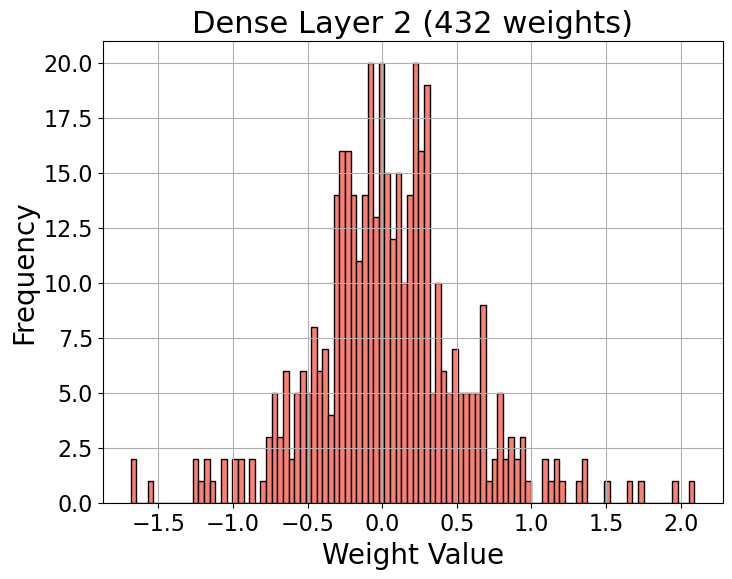

In [15]:
w10 = model.layers[10].weights[0].numpy()
h10, b10 = np.histogram(w10, bins=100)
num_weights10 = w10.size

plt.figure(figsize=(8, 6))
plt.hist(w10.flatten(), bins=100, color="salmon", edgecolor="black")
plt.xlabel("Weight Value", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title(f"Dense Layer 2 ({num_weights10} weights)", fontsize=22)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.grid(True)
plt.show()

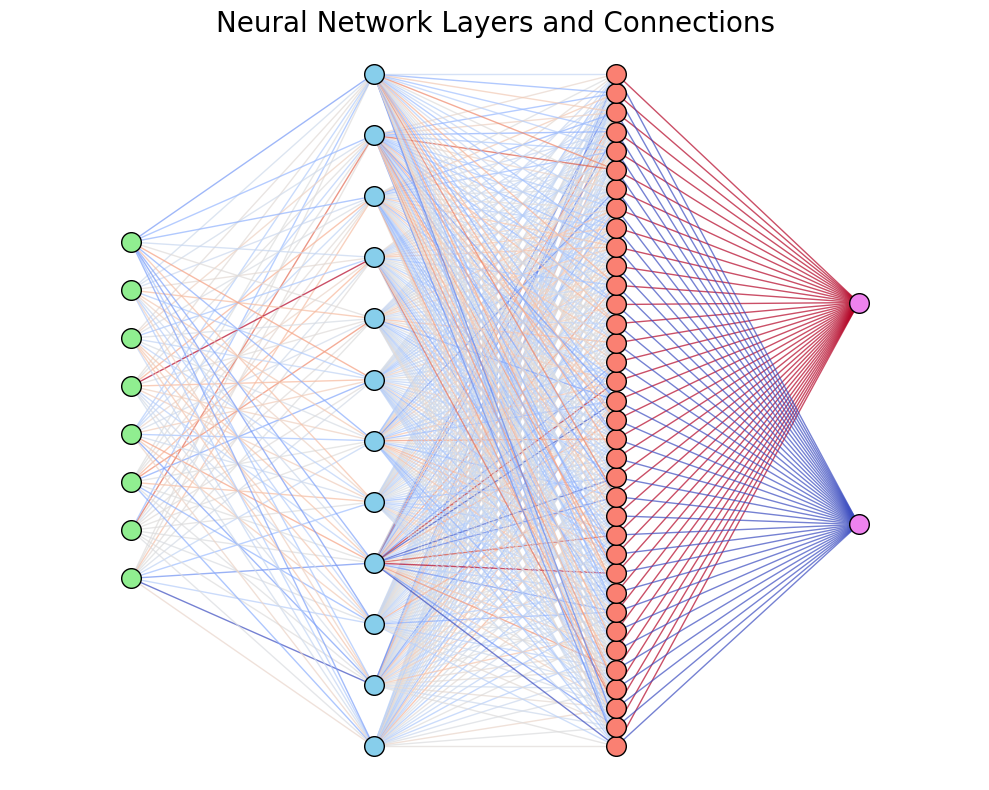

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))

# Number of neurons in each layer
n1 = w.shape[0]  # input to layer 1
n2 = w.shape[1]  # output of layer 1 / input to layer 2
n3 = w10.shape[1]  # output of layer 2
n4 = 2  # output of last layer (2 nodes)

# X positions for each layer
x1, x2, x3, x4 = 0, 1, 2, 3

# Y positions for each neuron
y1 = np.linspace(0.25, 0.75, n1)
y2 = np.linspace(0, 1, n2)
y3 = np.linspace(0, 1, n3)
y4 = np.linspace(0.33, 0.66, n4)

# Draw connections: input to layer 1
for i in range(n1):
    for j in range(n2):
        ax.plot(
            [x1, x2],
            [y1[i], y2[j]],
            color=plt.cm.coolwarm((w[i, j] - w.min()) / (w.max() - w.min())),
            alpha=0.7,
            linewidth=1,
        )

# Draw connections: layer 1 to layer 2
for i in range(n2):
    for j in range(n3):
        ax.plot(
            [x2, x3],
            [y2[i], y3[j]],
            color=plt.cm.coolwarm((w10[i, j] - w10.min()) / (w10.max() - w10.min())),
            alpha=0.7,
            linewidth=1,
        )

# Draw connections: layer 2 to last layer (random weights/colors for illustration)
for i in range(n3):
    for j in range(n4):
        ax.plot(
            [x3, x4],
            [y3[i], y4[j]],
            color=plt.cm.coolwarm(j / max(1, n4 - 1)),
            alpha=0.7,
            linewidth=1,
        )

# Draw neurons as dots
ax.scatter(
    [x1] * n1,
    y1,
    s=200,
    color="lightgreen",
    edgecolor="black",
    zorder=3,
    label="Layer 1",
)
ax.scatter(
    [x2] * n2, y2, s=200, color="skyblue", edgecolor="black", zorder=3, label="Layer 2"
)
ax.scatter(
    [x3] * n3, y3, s=200, color="salmon", edgecolor="black", zorder=3, label="Layer 3"
)
ax.scatter(
    [x4] * n4,
    y4,
    s=200,
    color="violet",
    edgecolor="black",
    zorder=3,
    label="Output Layer",
)

# Formatting
ax.set_xticks([x1, x2, x3, x4])
ax.set_xticklabels(["Layer 1", "Layer 2", "Layer 3", "Output"], fontsize=16)
ax.set_yticks([])
ax.set_xlim(-0.5, 3.5)
ax.set_title("Neural Network Layers and Connections", fontsize=20)
ax.axis("off")
plt.tight_layout()
plt.show()

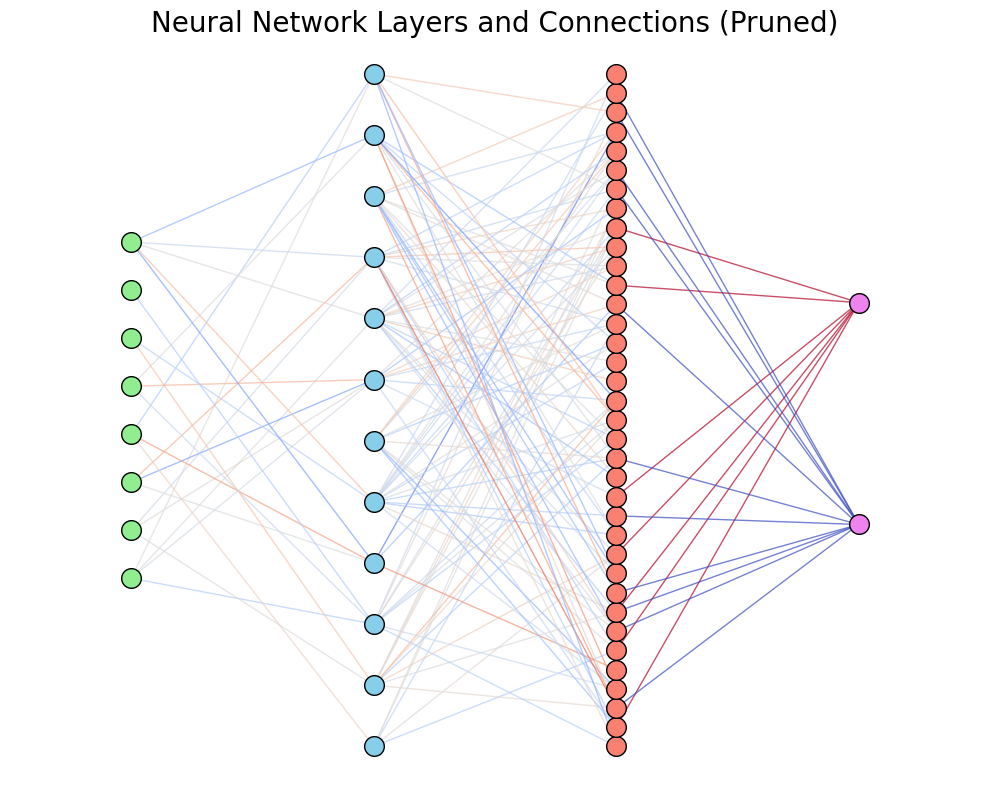

In [28]:
import random

fig, ax = plt.subplots(figsize=(10, 8))

# Number of neurons in each layer
n1 = w.shape[0]  # input to layer 1
n2 = w.shape[1]  # output of layer 1 / input to layer 2
n3 = w10.shape[1]  # output of layer 2
n4 = 2  # output of last layer (2 nodes)

# X positions for each layer
x1, x2, x3, x4 = 0, 1, 2, 3

# Y positions for each neuron
y1 = np.linspace(0.25, 0.75, n1)
y2 = np.linspace(0, 1, n2)
y3 = np.linspace(0, 1, n3)
y4 = np.linspace(0.33, 0.66, n4)


# Helper to randomly prune connections
def prune_connections(connections, keep_ratio=0.25):
    n_total = len(connections)
    n_keep = int(n_total * keep_ratio)
    keep_indices = set(random.sample(range(n_total), n_keep))
    return [conn for idx, conn in enumerate(connections) if idx in keep_indices]


# Generate all connections for each layer pair
conns_1_2 = [(i, j) for i in range(n1) for j in range(n2)]
conns_2_3 = [(i, j) for i in range(n2) for j in range(n3)]
conns_3_4 = [(i, j) for i in range(n3) for j in range(n4)]

# Prune 75% (keep 25%)
conns_1_2 = prune_connections(conns_1_2, keep_ratio=0.25)
conns_2_3 = prune_connections(conns_2_3, keep_ratio=0.25)
conns_3_4 = prune_connections(conns_3_4, keep_ratio=0.25)

# Draw pruned connections: input to layer 1
for i, j in conns_1_2:
    ax.plot(
        [x1, x2],
        [y1[i], y2[j]],
        color=plt.cm.coolwarm((w[i, j] - w.min()) / (w.max() - w.min())),
        alpha=0.7,
        linewidth=1,
    )

# Draw pruned connections: layer 1 to layer 2
for i, j in conns_2_3:
    ax.plot(
        [x2, x3],
        [y2[i], y3[j]],
        color=plt.cm.coolwarm((w10[i, j] - w10.min()) / (w10.max() - w10.min())),
        alpha=0.7,
        linewidth=1,
    )

# Draw pruned connections: layer 2 to last layer (random weights/colors for illustration)
for i, j in conns_3_4:
    ax.plot(
        [x3, x4],
        [y3[i], y4[j]],
        color=plt.cm.coolwarm(j / max(1, n4 - 1)),
        alpha=0.7,
        linewidth=1,
    )

# Draw neurons as dots
ax.scatter(
    [x1] * n1,
    y1,
    s=200,
    color="lightgreen",
    edgecolor="black",
    zorder=3,
    label="Layer 1",
)
ax.scatter(
    [x2] * n2, y2, s=200, color="skyblue", edgecolor="black", zorder=3, label="Layer 2"
)
ax.scatter(
    [x3] * n3, y3, s=200, color="salmon", edgecolor="black", zorder=3, label="Layer 3"
)
ax.scatter(
    [x4] * n4,
    y4,
    s=200,
    color="violet",
    edgecolor="black",
    zorder=3,
    label="Output Layer",
)

# Formatting
ax.set_xticks([x1, x2, x3, x4])
ax.set_xticklabels(["Layer 1", "Layer 2", "Layer 3", "Output"], fontsize=16)
ax.set_yticks([])
ax.set_xlim(-0.5, 3.5)
ax.set_title("Neural Network Layers and Connections (Pruned)", fontsize=20)
ax.axis("off")
plt.tight_layout()
plt.show()

In [22]:
fig, ax = plt.subplots(
    figsize=(10, 8)
)  # Number of neurons in each layern1 = w.shape[0]  # input to layer 1n2 = w.shape[1]  # output of layer 1 / input to layer 2n3 = w10.shape[1]  # output of layer 2n4 = 2  # output of last layer (new, only 2 nodes)# X positions for each layerx1, x2, x3, x4 = 0, 1, 2, 3# Y positions for each neurony1 = np.linspace(0, 1, n1)y2 = np.linspace(0, 1, n2)y3 = np.linspace(0, 1, n3)y4 = np.linspace(0, 1, n4)# Draw connections: input to layer 1for i in range(n1):    for j in range(n2):        ax.plot([x1, x2], [y1[i], y2[j]], color=plt.cm.coolwarm((w[i, j] - w.min()) / (w.max() - w.min())), alpha=0.7, linewidth=1)# Draw connections: layer 1 to layer 2for i in range(n2):    for j in range(n3):        ax.plot([x2, x3], [y2[i], y3[j]], color=plt.cm.coolwarm((w10[i, j] - w10.min()) / (w10.max() - w10.min())), alpha=0.7, linewidth=1)# Draw connections: layer 2 to last layer (random weights/colors for illustration)for i in range(n3):    for j in range(n4):        ax.plot([x3, x4], [y3[i], y4[j]], color=plt.cm.coolwarm(j / max(1, n4-1)), alpha=0.7, linewidth=1)# Draw neurons as dotsax.scatter([x1]*n1, y1, s=200, color='skyblue', edgecolor='black', zorder=3, label='Layer 1')ax.scatter([x2]*n2, y2, s=200, color='salmon', edgecolor='black', zorder=3, label='Layer 2')ax.scatter([x3]*n3, y3, s=200, color='lightgreen', edgecolor='black', zorder=3, label='Layer 3')ax.scatter([x4]*n4, y4, s=200, color='violet', edgecolor='black', zorder=3, label='Output Layer')# Formatting
ax.set_xticks([x1, x2, x3, x4])
ax.set_xticklabels(["Layer 1", "Layer 2", "Layer 3", "Output"], fontsize=16)
ax.set_yticks([])
ax.set_xlim(-0.5, 3.5)
ax.set_title("Neural Network Layers and Connections", fontsize=20)
ax.axis("off")
plt.tight_layout()
plt.show()